In [13]:
# Imports
import sys
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
import tempfile
import shutil

mount drive if running in google colab

In [14]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
    from image_utils import get_sample_image_size
    from csv_utils import split_classes, how_many
    from file_utils import train_test_split, num_images
    from google.colab import drive
    drive.mount('/content/drive')

else: 
    import sys
    sys.path.append("..")
    from src.utils.image_utils import get_sample_image_size
    from src.utils.csv_utils import split_classes, how_many
    from src.utils.file_utils import train_test_split, num_images

In Colab: False


set computation device


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")

Computation device: cpu


set hyper parameters


In [16]:
EPOCHS = 10
BATCH = 64

# percent of all data to go towards testing and validation
# TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15
LEARNING_RATE = 0.001

# spectrogram parameters
RESOLUTION = "low"
TRACK_DURATION = 15

# popularity thresholds
HIGH_THRESHOLD = 1400000
LOW_THRESHOLD = 175000

#### load the train and test data


In [17]:
# Setting paths
base_path = f"../data" if not IN_COLAB else f"/content/gdrive/MyDrive"
dir_name = f"ch_{RESOLUTION}_{TRACK_DURATION}_all"
spectrograms_path = f"{base_path}/spectrograms/{dir_name}"
csv_path = f"{base_path}/audio_features.csv"
df = pd.read_csv(csv_path)

print(f"Csv Length: {len(df)}")
print(f"Number of spectrograms: {num_images(spectrograms_path)}")

above_threshold = how_many(
    csv_path, 'number_of_videos', HIGH_THRESHOLD, 'above')
below_threshold = how_many(
    csv_path, 'number_of_videos', LOW_THRESHOLD, 'below')
    
print(f"Number of tracks above threshold: {above_threshold}")
print(f"Number of tracks below threshold: {below_threshold}")

Csv Length: 3932
Number of spectrograms: 3914
Number of tracks above threshold: 509
Number of tracks below threshold: 497


In [18]:
image_size = get_sample_image_size(spectrograms_path)
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")

Number of channels in the image: 1
height: 128, width: 162


In [19]:
transform = transforms.Compose(
    [
        transforms.Resize((HEIGHT, WIDTH)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

def get_datasets():

    # create temporary folder to store spectrograms
    root_dir = "../data/" if not IN_COLAB else '.'
    temp_dir = tempfile.mkdtemp(dir=root_dir)

    # split into two classes based on popularity thresholds
    out_path = f"{temp_dir}/"
    split_classes(
        csv_path, spectrograms_path, out_path, ["viral", "notviral"], HIGH_THRESHOLD, LOW_THRESHOLD
    )

    # copy spectrograms to temporary folder split into train and test directories
    data_dir = tempfile.mkdtemp(dir=root_dir)
    train_dir, test_dir = train_test_split(temp_dir, data_dir, PERCENT_TESTING)
    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    # delete temporary folder
    shutil.rmtree(temp_dir)
    return train_dataset, test_dataset, data_dir

In [20]:
train_dataset, test_dataset, data_dir = get_datasets()

print(f"number of training images: {len(train_dataset)}")
print(f"number of testing images: {len(test_dataset)}")

cp: ../data/spectrograms/ch_low_15_all/30kXwHubMQ6NXloIz1NLbF.png: No such file or directory
cp: ../data/spectrograms/ch_low_15_all/1d4jA5QssQiacYMtQhyI3K.png: No such file or directory


Number of files in viral: 508
Number of files in notviral: 496
Number of images per class: [496, 508]
Number of testing images per class: [74, 76]
Processing class: notviral
Created subdirectories: ../data/tmp1v9vt_6n/training/notviral and ../data/tmp1v9vt_6n/testing/notviral
Processing class: viral
Created subdirectories: ../data/tmp1v9vt_6n/training/viral and ../data/tmp1v9vt_6n/testing/viral
number of training images: 854
number of testing images: 150


#### Looking at the dataset


In [21]:
img, label = train_dataset[0]
print(img.shape, label)
print("classes : \n", train_dataset.classes)

# num images per class
print("num images per class")
print(train_dataset.targets.count(0))
print(train_dataset.targets.count(1))

torch.Size([1, 128, 162]) 0
classes : 
 ['notviral', 'viral']
num images per class
422
432


display the first image in the dataset


Label : notviral


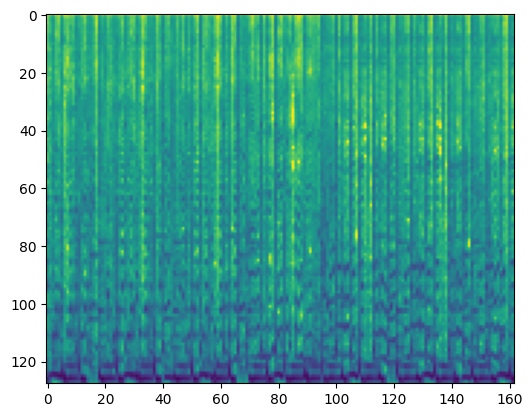

In [22]:
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))


display_img(*train_dataset[0])

load the train and validation into batches.


In [23]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(len(train_dataset) * PERCENT_VALIDATION)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)

Length of Train Data : 726
Length of Validation Data : 128


visualize a single batch of images


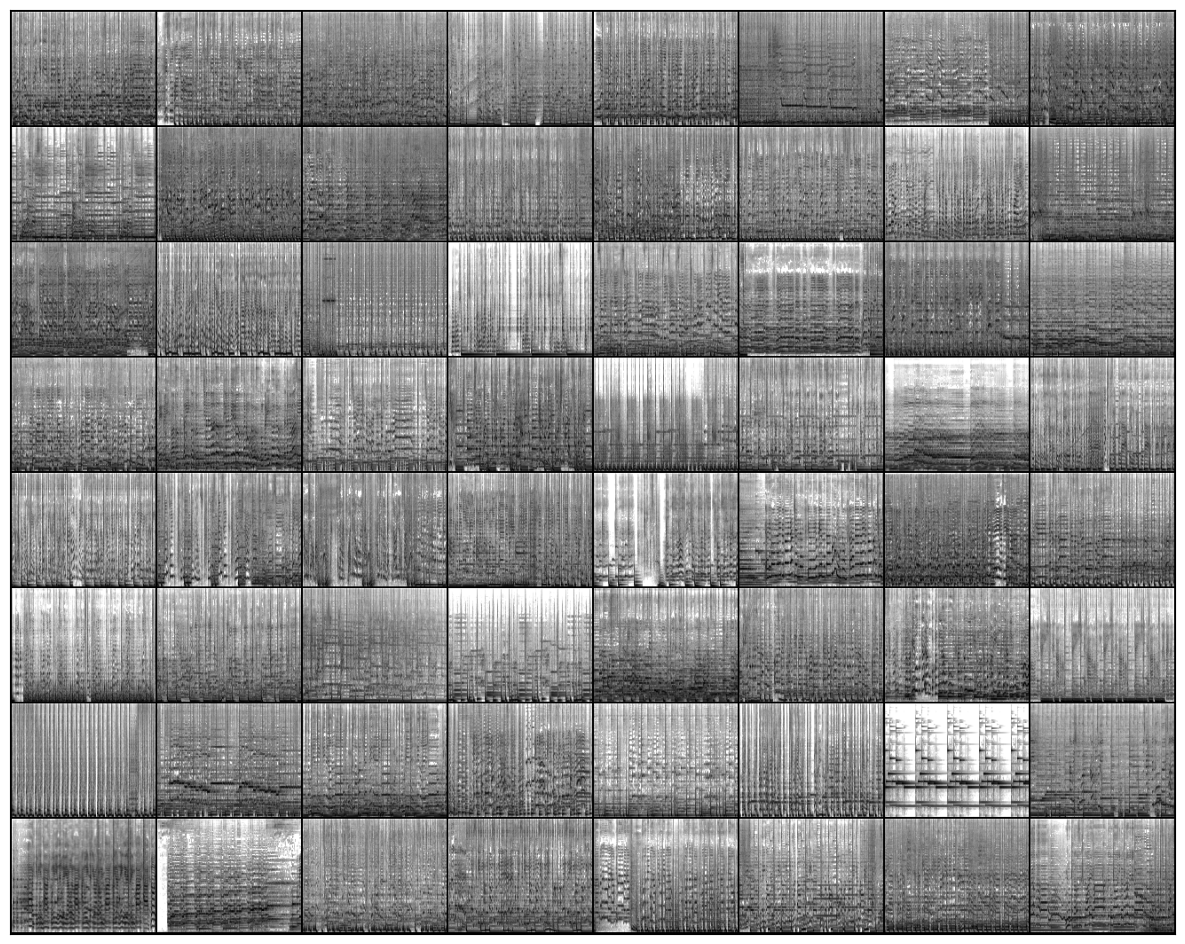

In [24]:
from torchvision.utils import make_grid


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


show_batch(train_dl)

In [25]:
import torch.nn as nn


class VGG11(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate the size of the feature maps after convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_output_size = self.calculate_conv_output_size(
            in_channels, WIDTH, HEIGHT
        )

        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=self.conv_output_size, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes),
        )

    def calculate_conv_output_size(self, in_channels, width, height):
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, width, height)
            dummy_output = self.conv_layers(dummy_input)
            print(f"Dummy output shape: {dummy_output.shape}")
            return dummy_output.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Initialize model:


In [26]:
model = VGG11(in_channels=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Dummy output shape: torch.Size([1, 512, 5, 4])


Function for training (one epoch)


In [27]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    cum_loss = 0.0
    cum_correct = 0

    for x, y in tqdm(trainloader, total=len(trainloader), desc="Training"):
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        cum_correct += (pred.argmax(1) == y).sum().item()

    epoch_acc = cum_correct / len(trainloader.dataset)
    epoch_loss = cum_loss / len(trainloader)
    return epoch_acc, epoch_loss

Function for testing (one epoch)


In [28]:
def test(model, testloader, criterion):
    model.eval()
    cum_loss = 0.0
    cum_correct = 0

    with torch.no_grad():
        for x, y in tqdm(testloader, total=len(testloader), desc="Testing"):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)

            loss = criterion(pred, y)
            cum_loss += loss
            cum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_acc = cum_correct / len(testloader.dataset)
    epoch_loss = cum_loss / len(testloader)
    return epoch_acc, epoch_loss

Training and testing the model:


In [29]:
# dictionary to keep track of losses and accuracies
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

# train the model
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_acc, train_epoch_loss = train(
        model, train_dl, optimizer, criterion)
    test_epoch_acc, test_epoch_loss = test(model, test_dl, criterion)
    # print all the metrics
    print(
        f"Train loss: {train_epoch_loss:.4f} | Train acc: {train_epoch_acc:.4f}")
    print(f"Test loss: {test_epoch_loss:.4f} | Test acc: {test_epoch_acc:.4f}")
    H["train_loss"].append(train_epoch_loss)
    H["train_acc"].append(train_epoch_acc)
    H["test_loss"].append(test_epoch_loss)
    H["test_acc"].append(test_epoch_acc)

Epoch 1 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6982 | Train acc: 0.4945
Test loss: 0.6957 | Test acc: 0.4933
Epoch 2 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6896 | Train acc: 0.5193
Test loss: 0.6933 | Test acc: 0.4667
Epoch 3 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6888 | Train acc: 0.5372
Test loss: 0.7078 | Test acc: 0.4933
Epoch 4 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6784 | Train acc: 0.5661
Test loss: 0.6956 | Test acc: 0.4800
Epoch 5 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6763 | Train acc: 0.5826
Test loss: 0.6985 | Test acc: 0.5000
Epoch 6 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6799 | Train acc: 0.5592
Test loss: 0.6759 | Test acc: 0.5667
Epoch 7 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6715 | Train acc: 0.5992
Test loss: 0.6767 | Test acc: 0.5667
Epoch 8 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6633 | Train acc: 0.5937
Test loss: 0.6796 | Test acc: 0.5667
Epoch 9 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6634 | Train acc: 0.6198
Test loss: 0.6651 | Test acc: 0.5867
Epoch 10 of 10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

NameError: name 'H' is not defined

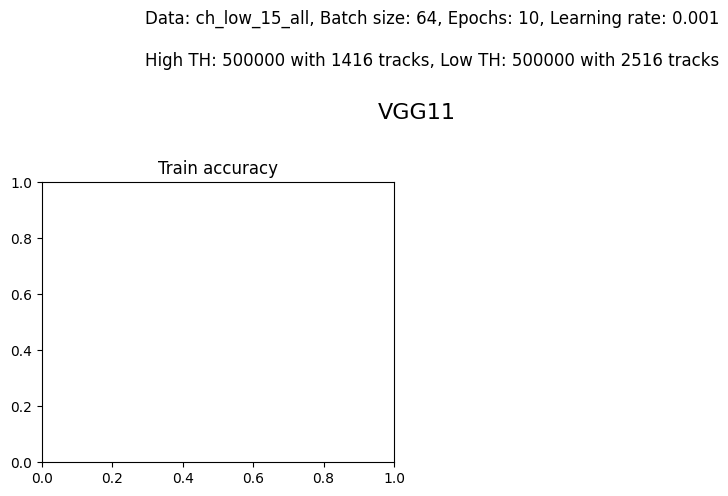

In [ ]:
fig = plt.figure(figsize=(10, 8))
# supertitle
fig.suptitle("VGG11", fontsize=16)
info = f"""Data: {dir_name}, Batch size: {BATCH}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}\n
High TH: {HIGH_THRESHOLD} with {above_threshold} tracks, Low TH: {LOW_THRESHOLD} with {below_threshold} tracks\n"""
fig.text(
    0.515, 1, info, ha='center', fontsize=12)


sub1 = fig.add_subplot(221)
sub1.set_title('Train accuracy')
sub1.plot(H["train_acc"], color='blue', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

sub2 = fig.add_subplot(222)
sub2.set_title('Test accuracy')
sub2.plot(H["test_acc"], color='red', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

sub3 = fig.add_subplot(223)
sub3.set_title('Train loss')
sub3.plot(H["train_loss"], color='green', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')


sub4 = fig.add_subplot(224)
sub4.set_title('Test loss')
sub4.plot([l.item() for l in H["test_loss"]], color='orange', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# save figure